### 1. IMPORT

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series
import numpy as np
!pip install klib
!pip install optuna
!pip install bayesian-optimization
!pip install catboost
!pip install -q -U keras-tuner

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
plt.rc('font', family='AppleGothic')
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False 


# EDA
import klib


# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from gensim.models import word2vec
import kerastuner as kt

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization


# Modeling
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
import optuna


# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss


# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
!pip install shap
import tensorflow as tf
from tensorflow import keras
import joblib
print(tf.__version__)
import gc

  Using cached optuna-2.10.0-py3-none-any.whl (308 kB)
  Using cached cmaes-0.8.2-py3-none-any.whl (15 kB)
  Using cached autopage-0.4.0-py3-none-any.whl (20 kB)
  Using cached pyperclip-1.8.2.tar.gz (20 kB)
  Using cached pyreadline3-3.3-py3-none-any.whl (95 kB)
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11112 sha256=b054c077f2639833f4b473b0ca3e770564acbe3ef7f3e3547a1a23450c712683
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\7f\1a\65\84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Using cached bayesian-optimization-1.2.0.tar.gz (14 kB)
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11690 sha256=8fcf5286cbe98008b048af24499e0ed7f563049c03aa0092ff37a63fd8b2c1df
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\37\fa\19\f93e793d3944567a60b3ab93b446cf7370cc82c60c1d1c613f
Successfully built bayesian-optimization


ModuleNotFoundError: No module named 'gensim'

## 데이터 불러오기 및 시드 생성

In [2]:
SHAP_THRESHOLD = 0    # feature로 사용할 최소 SHAP feature importance
DATA_REDUCTION = 1.0  # 학습 데이터 축소 비율
TRAIN_RATIO = 0.6     # 학습 데이터를 Train과 Validation으로 나누는 비율

In [3]:
# 매번 모델링을 할 때마다 동일한 결과를 얻기 위해 랜덤 시드 설정 동일하게 유지
# 럭키 시드 찾는건 시간상 어려움

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train = pd.read_csv(os.path.abspath("../input") + '/response_train.csv')
train.sort_values(by='TIME',inplace=True)

panel = pd.read_csv(os.path.abspath("../input") + '/panel.csv')

test = pd.read_csv(os.path.abspath("../input") + '/response_test.csv').sort_values(by='ID')

survey = pd.read_csv(os.path.abspath("../input") + '/survey.csv')

### survey 가성비 컬럼 생성

In [5]:
survey['EFC'] = survey['CPI'] / survey['LOI']

## Panel  데이터 정리

### 패널 질문 응답수

In [6]:
panel_Questions = panel.iloc[:,4:]

panel_Questions_count = []
for i in range(panel_Questions.shape[0]):
            panel_Questions_count.append(pd.notna(panel_Questions.iloc[i,:].values).sum())

panel['Questions_count'] = panel_Questions_count

### panel - 데이터 정제 및 병합

In [7]:
# 성별, 지역 값이 Nan 값인 패널 1명 test에도 존재 하지 않아 그냥 drop
panel.drop(8315, axis=0, inplace=True)

In [8]:
# 겹치는 columms 제거  # sq1,sq2,sq3가 BIRTH, GENDER, REGION 컬럼보다 결측치가 더 많음.

del panel['SQ1']

del panel['SQ2']

del panel['SQ3']

In [9]:
# merge

train=pd.merge(pd.merge(train,panel,on="userID"),survey,on="surveyID")

test=pd.merge(pd.merge(test,panel,on="userID"),survey,on="surveyID")

###panel 데이터 정제

#### 결측치 30%이상이면 버림

In [10]:
# 결측값 비율이 % 이하인 column만 사용
features = []
for f in train.columns:
    if train[f].isnull().sum()/train.shape[0] > 0.3:
        print(f, '\t', train[f].nunique(), '\t', train[f].isnull().sum()/train.shape[0])
        features.append(f)

B4 	 733 	 0.30726936583927594
B5 	 719 	 0.3123738732575725
C1 	 1819 	 0.3676381080820416
C2 	 84 	 0.47678798962460034
C3 	 1110 	 0.48999233936471576
F1 	 146 	 0.518416415984934
F2 	 83 	 0.5308220777184397
H1 	 865 	 0.5505034058935712
T1 	 91 	 0.557678548161784
X1 	 70 	 0.5767936377373865
X2 	 55 	 0.5855288417718925
X3 	 48 	 0.603304288711951
X4 	 61 	 0.635134564757856
DQ1 	 63 	 0.6571707685491058
DQ2 	 155 	 0.6632203663198752
DQ3 	 147 	 0.6718042743367902
DQ4 	 77 	 0.6739833855766774
DQ5 	 9 	 0.6802054852758593
DQ6 	 11 	 0.6811175433441681
DQ7 	 12 	 0.6852596286559551
CATEGORIES 	 91 	 0.8198596617290198


In [11]:
train.drop(columns = features, inplace = True)
test.drop(columns = features, inplace = True)

#### SQ4 ~ B3 처리 - 교수님 

In [13]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,']:
        return int(x[0])
    else:
        return 99

train.SQ4 = train.SQ4.apply(handle_profile)
test.SQ4 = test.SQ4.apply(handle_profile)

In [14]:
def handle_profile(x):
    if x in ['1', '2', '3', '4']:
        return int(x)
    elif x in ['1.0', '2.0', '3.0', '4.0']:
        return int(x[0])
    else:
        return 99

train.SQ5 = train.SQ5.apply(handle_profile)
test.SQ5 = test.SQ5.apply(handle_profile)

In [15]:
def handle_profile(x):
    if x in ['1', '2']:
        return int(x)
    elif x in ['1,', '2,']:
        return int(x[0])
    else:
        return 99

train.SQ6 = train.SQ6.apply(handle_profile)
test.SQ6 = test.SQ6.apply(handle_profile)

In [16]:
value1 = pd.Series(range(1,17)).apply(lambda x: str(x)).tolist()
value2 = pd.Series(np.arange(1.0,17.0)).apply(lambda x: str(x)).tolist()
def handle_profile(x):
    if x in value1:
        return int(x)
    elif x in value2:
        return int(x[0])
    else:
        return 99

train.SQ7 = train.SQ7.apply(handle_profile)
test.SQ7 = test.SQ7.apply(handle_profile)

In [17]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5']:
        return int(x)
    else:
        return 99

train.SQ8 = train.SQ8.apply(handle_profile)
test.SQ8 = test.SQ8.apply(handle_profile)

In [18]:
values = pd.Series(range(1,23)).apply(lambda x: str(x)).tolist()
def handle_profile(x):    
    if x in values:
        return int(x)
    else:
        return 99

train.A1 = train.A1.apply(handle_profile)
test.A1 = test.A1.apply(handle_profile)

In [19]:
def handle_profile(x):    
    if x in ['1']:
        return 2
    elif x in ['2', '3']:
        return 3
    elif x in ['4', '5', '6', '7']:
        return 4
    elif x in ['8']:
        return 5
    else:
        return 99

train.B1 = train.B1.apply(handle_profile)
test.B1 = test.B1.apply(handle_profile)

In [20]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    else:
        return 99

train.B2 = train.B2.apply(handle_profile)
test.B2 = test.B2.apply(handle_profile)

In [21]:
def handle_profile(x):    
    if x in ['1', '2', '3']:
        return int(x)
    elif x in ['1,', '2,', '3,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B3 = train.B3.apply(handle_profile)
test.B3 = test.B3.apply(handle_profile)

###시간대별 트레인 분할

In [22]:
train['TIME'] = train['TIME'].astype("datetime64")
test['TIME'] = test['TIME'].astype("datetime64")
before_train = train.query("TIME <= '2021-01-01 00:00:00'")
train = train.query("TIME>='2021-01-01 00:00:00'")

In [23]:
def null_x(x):
    global train; global test;
    for filln in x:
        train = train.merge(train.groupby(['BIRTH','GENDER','TYPE','Questions_count','SQ5','SQ6'])[filln].agg([('exp', np.mean)]).reset_index(), on=['BIRTH','GENDER','TYPE','Questions_count','SQ5','SQ6'], how='left')
        train[filln] = np.where(train[filln].isna(), train['exp'], train[filln])
        train.drop(labels="exp",axis=1, inplace=True)
        train[filln] = train[filln].fillna(0)

        test = test.merge(test.groupby(['BIRTH','GENDER','TYPE','Questions_count','SQ5','SQ6'])[filln].agg([('exp', np.mean)]).reset_index(), on=['BIRTH','GENDER','TYPE','Questions_count','SQ5','SQ6'], how='left')
        test[filln] = np.where(test[filln].isna(), test['exp'], test[filln])
        test.drop(labels="exp",axis=1, inplace=True)
        test[filln] = test[filln].fillna(0)

## 피쳐 생성

### 시간 피쳐

In [24]:
data = [train,test]
for i in data:
    i['DAY'] = i['TIME'].dt.day
    i['WEEKDAY'] = i['TIME'].dt.dayofweek
    i['HOUR'] = i['TIME'].dt.hour
    i['HOUR_range'] = pd.cut(i['HOUR'], 4, labels = ['새벽', '오전', '오후', '야간'], right = True, include_lowest=True)

### 패널ID별 누적 평균 포인트

In [25]:
Points_earned_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()
Points_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()
train = train.merge(Points_earned_b, how='left')

test = test.merge(Points_earned_b, how='left')


In [26]:
Points_earned_mean = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()
Points_earned_mean1 = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()
train = train.merge(Points_earned_mean, how='left')

test = test.merge(Points_earned_mean, how='left')


In [27]:
null_x(["Points_earned",'Points_earned_mean'])

In [28]:
train['CPI_mean'] = train['Points_earned_mean'] < train['CPI']
train['CPI_mean'] = train['CPI_mean'].apply(lambda x : 1 if x==True else 0)


test['CPI_mean'] = test['Points_earned_mean'] < test['CPI']
test['CPI_mean'] = test['CPI_mean'].apply(lambda x : 1 if x==True else 0)


### 패널ID별 누적 평균 난이도

In [29]:
IR_mean_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['IR'].agg([('Difficulty_earned_mean',np.mean)])).reset_index()

IR_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['IR'].agg([('Difficulty_earned__mean',np.mean)])).reset_index()


train = train.merge(IR_mean_b, how='left')

test = test.merge(IR_mean_b, how='left')

In [30]:
IR_sum_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['IR'].agg([('Difficulty_earned_sum',np.sum)])).reset_index()

IR_sum = pd.DataFrame(train.query('STATUS==1').groupby('userID')['IR'].agg([('Difficulty_earned_sum',np.sum)])).reset_index()


train = train.merge(IR_sum_b, how='left')

test = test.merge(IR_sum_b, how='left')

In [31]:
null_x(["Difficulty_earned_sum",'Difficulty_earned_mean'])

In [32]:
train['IR_eff'] = train['Difficulty_earned_mean'] > train['IR']
train['IR_eff'] = train['IR_eff'].apply(lambda x : 1 if x==True else 0)


test['IR_eff'] = test['Difficulty_earned_mean'] > test['IR']
test['IR_eff'] = test['IR_eff'].apply(lambda x : 1 if x==True else 0)


### 패널ID별 누적 평균 시간

In [33]:
Time_earned_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['LOI'].agg([('Time_earned',np.sum)])).reset_index()
Time_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['LOI'].agg([('Time_earned',np.sum)])).reset_index()
train = train.merge(Time_earned_b, how='left')
test = test.merge(Time_earned_b, how='left')

In [34]:
Time_earned_mean = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['LOI'].agg([('Time_earned_mean',np.mean)])).reset_index()
Time_earned_mean1 = pd.DataFrame(train.query('STATUS==1').groupby('userID')['LOI'].agg([('Time_earned_mean',np.mean)])).reset_index()
train = train.merge(Time_earned_mean, how='left')

test = test.merge(Time_earned_mean, how='left')


In [35]:
null_x(["Time_earned",'Time_earned_mean'])

In [36]:
train['LOI_eff_mean'] = train['Time_earned_mean'] > train['LOI']
train['LOI_eff_mean'] = train['LOI_eff_mean'].apply(lambda x : 1 if x==True else 0)


test['LOI_eff_mean'] = test['Time_earned_mean'] > test['LOI']
test['LOI_eff_mean'] = test['LOI_eff_mean'].apply(lambda x : 1 if x==True else 0)


### 패널ID별 누적 평균 가성비

In [37]:
Time_earned_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['EFC'].agg([('EFC_earned',np.sum)])).reset_index()
Time_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['EFC'].agg([('EFC_earned',np.sum)])).reset_index()
train = train.merge(Time_earned_b, how='left')

test = test.merge(Time_earned_b, how='left')


In [38]:
Time_earned_mean = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['EFC'].agg([('EFC_earned_mean',np.mean)])).reset_index()
Time_earned_mean1 = pd.DataFrame(train.query('STATUS==1').groupby('userID')['EFC'].agg([('EFC_earned_mean',np.mean)])).reset_index()
train = train.merge(Time_earned_mean, how='left')

test = test.merge(Time_earned_mean, how='left')


In [39]:
null_x(["EFC_earned",'EFC_earned_mean'])

In [40]:
train['CPI_eff_mean'] = train['EFC_earned_mean'] < train['EFC']
train['CPI_eff_mean'] = train['CPI_eff_mean'].apply(lambda x : 1 if x==True else 0)


test['CPI_eff_mean'] = test['EFC_earned_mean'] < test['EFC']
test['CPI_eff_mean'] = test['CPI_eff_mean'].apply(lambda x : 1 if x==True else 0)


### 패널별 리워드, 난이도, 시간, 가성비 최대 최소 비교

In [41]:
# CPI MIN
user_CPI_min = before_train.groupby('userID')['CPI'].agg([('user_CPI_min', np.min)]).reset_index()

train = train.merge(user_CPI_min[['userID','user_CPI_min']], on = 'userID', how= 'left')

test = test.merge(user_CPI_min[['userID','user_CPI_min']], on = 'userID', how= 'left')

In [42]:
null_x(["user_CPI_min"])

In [43]:
train['CPI_min'] = train['user_CPI_min'] < train['CPI']
train['CPI_min'] = train['CPI_min'].apply(lambda x : 1 if x==True else 0)
train.drop(labels="user_CPI_min",axis=1,inplace=True)

test['CPI_min'] = test['user_CPI_min'] < test['CPI']
test['CPI_min'] = test['CPI_min'].apply(lambda x : 1 if x==True else 0)
test.drop(labels="user_CPI_min",axis=1,inplace=True)

In [44]:
# IR MAX
user_IR_max = before_train.groupby('userID')['IR'].agg([('user_IR_max', np.max)]).reset_index()

train = train.merge(user_IR_max[['userID','user_IR_max']], on = 'userID', how= 'left')


test = test.merge(user_IR_max[['userID','user_IR_max']], on = 'userID', how= 'left')


In [45]:
null_x(["user_IR_max"])

In [46]:
train['IR_max'] = train['user_IR_max'] > train['IR']
train['IR_max'] = train['IR_max'].apply(lambda x : 1 if x==True else 0)
train.drop(labels="user_IR_max",axis=1,inplace=True)

test['IR_max'] = test['user_IR_max'] > test['IR']
test['IR_max'] = test['IR_max'].apply(lambda x : 1 if x==True else 0)
test.drop(labels="user_IR_max",axis=1,inplace=True)

In [47]:
# LOI MAX
user_LOI_max = before_train.groupby('userID')['LOI'].agg([('user_LOI_max', np.max)]).reset_index()

train = train.merge(user_LOI_max[['userID','user_LOI_max']], on = 'userID', how= 'left')


test = test.merge(user_LOI_max[['userID','user_LOI_max']], on = 'userID', how= 'left')


In [48]:
null_x(["user_LOI_max"])

In [49]:
train['LOI_max'] = train['user_LOI_max'] > train['LOI']
train['LOI_max'] = train['LOI_max'].apply(lambda x : 1 if x==True else 0)
train.drop(labels="user_LOI_max",axis=1,inplace=True)

test['LOI_max'] = test['user_LOI_max'] > test['LOI']
test['LOI_max'] = test['LOI_max'].apply(lambda x : 1 if x==True else 0)
test.drop(labels="user_LOI_max",axis=1,inplace=True)

In [50]:
# EFC MIN
user_EFC_min = before_train.groupby('userID')['EFC'].agg([('user_EFC_min', np.min)]).reset_index()

train = train.merge(user_EFC_min[['userID','user_EFC_min']], on = 'userID', how= 'left')


test = test.merge(user_EFC_min[['userID','user_EFC_min']], on = 'userID', how= 'left')


In [51]:
null_x(["user_EFC_min"])

In [52]:
train['EFC_min'] = train['user_EFC_min'] < train['EFC']
train['EFC_min'] = train['EFC_min'].apply(lambda x : 1 if x==True else 0)
train.drop(labels="user_EFC_min",axis=1,inplace=True)

test['EFC_min'] = test['user_EFC_min'] < test['EFC']
test['EFC_min'] = test['EFC_min'].apply(lambda x : 1 if x==True else 0)
test.drop(labels="user_EFC_min",axis=1,inplace=True)

### 응답율 

In [53]:
### 응답율

res_freq = train.query('STATUS == 1').groupby('userID')['userID'].agg([('FREQ',np.size)]).reset_index()
send_freq = train.groupby('userID')['userID'].agg([('SEND',np.size)]).reset_index()
train = train.merge(res_freq,how="left").merge(send_freq,how="left")
train['RESRATE'] = train['FREQ'] / train['SEND']
del  train['SEND'],train['FREQ']

test = test.merge(res_freq,how="left").merge(send_freq,how="left")
test['RESRATE'] = test['FREQ'] / test['SEND']
del  test['SEND'],test['FREQ']

train['RESRATE']
test['RESRATE']
#null_x(["RESRATE"])

0          0.783951
1          0.094444
2          0.338384
3          0.895238
4          0.009217
             ...   
1355512    0.130719
1355513         NaN
1355514    0.461538
1355515    0.461538
1355516    0.461538
Name: RESRATE, Length: 1355517, dtype: float64

### 성별별 난이도 평균

In [54]:
res_freq = before_train.query('STATUS == 1').groupby('GENDER')['IR'].agg([('g_i','mean')]).reset_index()
train = pd.merge(train, res_freq, how='left')

test = pd.merge(test, res_freq, how='left')

### 타이틀

In [55]:
import re

word_counts = {}
def count_word(x): # 응답한 서베이 제목에서 한글 단어만 분리하고 빈도 계산
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x): # 빈도의 합으로 제목을 Encoding
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

In [56]:
y_train = train['STATUS']
train.drop('STATUS', axis=1, inplace=True)

test_id = test.iloc[:,0:1]
test.drop('ID', axis=1, inplace=True)

In [57]:
#성능 개선에 무의미한 Feature 제거
train.drop(['userID', 'surveyID', 'TIME'], axis=1, inplace=True)
test.drop(['userID', 'surveyID', 'TIME'], axis=1, inplace=True)

## 결측치 처리

### 나머지는 범주형은 새로운 값으로 대치하고 결측값이 있는 수치형은 0으로 대치

In [58]:
cat_list=['BIRTH', 'GENDER', 'REGION','TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3','HOUR_range']

In [59]:
num_list=list(set(train.columns)-set(cat_list))

In [60]:
train[cat_list]=train[cat_list].astype("category")
test[cat_list]=test[cat_list].astype("category")

In [61]:
for i in cat_list:
    train[i] =train[i].cat.add_categories('unknown')
    test[i] =test[i].cat.add_categories('unknown')
    train[i].fillna("unknown",inplace=True)
    test[i].fillna("unknown",inplace=True)

for i in num_list:
    train[i].fillna(0,inplace=True)
    test[i].fillna(0,inplace=True)

## 데이터 스케일링  스탠다드 스케일 + 원핫인코딩

In [62]:
#StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[num_list] = scaler.fit_transform(train[num_list])
test[num_list] = scaler.transform(test[num_list])

In [63]:
# 원핫 인코딩
df_encoded = pd.get_dummies(pd.concat([train, test]), columns=cat_list)
X_train = df_encoded[:train.shape[0]]
X_test = df_encoded[train.shape[0]:]

## 피쳐 셀렉션

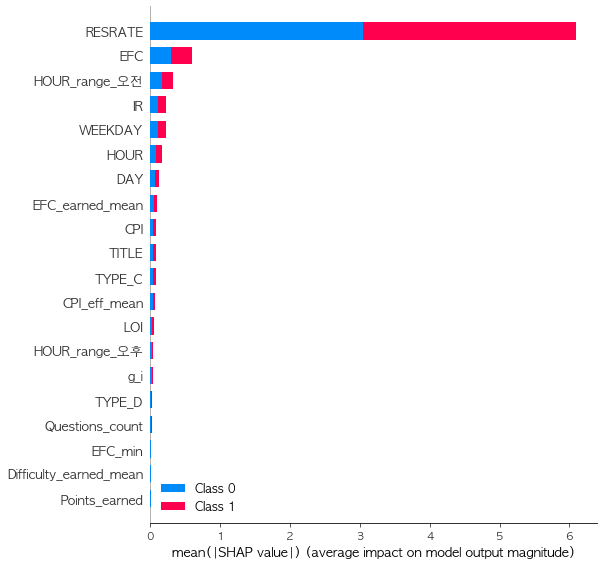

column_name shap_importance
25              RESRATE        3.044693
5                   EFC         0.30016
217       HOUR_range_오전        0.164079
2                    IR        0.110958
7               WEEKDAY        0.109274
..                  ...             ...
90         BIRTH_1997.0             0.0
91         BIRTH_1998.0             0.0
92         BIRTH_1999.0             0.0
93         BIRTH_2000.0             0.0
220  HOUR_range_unknown             0.0

[221 rows x 2 columns]

In [64]:
# Method: Using SHAP values 
import shap
from lightgbm import LGBMClassifier

# DF, based on which importance is checked
X_importance = X_train

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [65]:
# feature 중요도가 0 이상
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
train = X_train[features_selected]
test =X_test[features_selected]
print(train.shape)

(1979651, 50)


In [69]:
import joblib
#with open('01.1.read_data.pkl', 'wb') as f:
#    joblib.dump({'train' : train, 'test' : test, 'y_train':y_train, 'test_id':test_id }, f)

## 모델 생성

In [2]:
#with open('01.1.read_data.pkl', 'rb') as f:
    #pkl_data = joblib.load(f)
#locals().update(pkl_data)

In [3]:
y_train_all=y_train

In [4]:
y_train_all=y_train
# test size 올리기위해 0.4
X_train, X_dev, y_train, y_dev = train_test_split(train, y_train, test_size=0.4, random_state=77) 
evals = [(X_dev, y_dev)] 
X_train1, X_dev1, y_train1, y_dev1 = train_test_split(train, y_train_all, test_size=0.3, random_state=77) 

In [5]:
# 모델 앙상블 클래스

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in self.estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in self.estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict(X).flatten()  if "Functional" in name  else clf.predict_proba(X)[:,1] for name, clf  in self.estimators], axis=0)
        else:
            probs = [clf.predict(X).flatten()  if "Functional" in name  else clf.predict_proba(X)[:,1] for name, clf  in self.estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return prob

### DNN 시드 돌려서 평균 찾기

In [75]:
# reset_seeds()함수를 아래와 같이 수정해야 함.
def reset_seeds(SEED, reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(SEED)
    random.seed(SEED)
    tf.compat.v1.set_random_seed(SEED)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional

In [76]:
# 예측값을 저장할 폴더 생성
folder = 'Ensemble'
if not os.path.isdir(folder):
    os.mkdir(folder)

In [77]:
for i in tqdm(range(20)):    
    SEED = np.random.randint(1, 10000)              
    reset_seeds(SEED)
    
    # Define the NN architecture
    input = keras.Input(shape=(X_train.shape[1],))
    x = keras.layers.Dense(32, activation='relu')(input)
    x = keras.layers.Dense(16, activation='relu')(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(input, output)    

    # Choose the optimizer and the cost function
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Nadam(lr=0.001), metrics=['acc', keras.metrics.AUC()])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), batch_size=4096, epochs=50, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    # Make submissions
    submission = pd.DataFrame({
        "ID": test_id.ID, 
        "STATUS": model.predict(test).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/loop_submission_{t.month:02}{t.day:02}_{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

  0%|                                                    | 0/20 [00:00<?, ?it/s]2021-12-14 02:51:05.159764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


RANDOM SEEDS RESET


  5%|██▏                                         | 1/20 [00:56<17:44, 56.04s/it]

RANDOM SEEDS RESET


 10%|████▍                                       | 2/20 [01:47<16:04, 53.59s/it]

RANDOM SEEDS RESET


 15%|██████▌                                     | 3/20 [02:38<14:50, 52.36s/it]

RANDOM SEEDS RESET


 20%|████████▊                                   | 4/20 [03:30<13:52, 52.06s/it]

RANDOM SEEDS RESET


 25%|███████████                                 | 5/20 [04:20<12:52, 51.50s/it]

RANDOM SEEDS RESET


 30%|█████████████▏                              | 6/20 [05:11<11:57, 51.25s/it]

RANDOM SEEDS RESET


 35%|███████████████▍                            | 7/20 [06:03<11:09, 51.49s/it]

RANDOM SEEDS RESET


 40%|█████████████████▌                          | 8/20 [06:54<10:16, 51.34s/it]

RANDOM SEEDS RESET


 45%|███████████████████▊                        | 9/20 [07:46<09:25, 51.43s/it]

RANDOM SEEDS RESET


 50%|█████████████████████▌                     | 10/20 [08:37<08:32, 51.20s/it]

RANDOM SEEDS RESET


 55%|███████████████████████▋                   | 11/20 [09:31<07:48, 52.07s/it]

RANDOM SEEDS RESET


 60%|█████████████████████████▊                 | 12/20 [10:23<06:57, 52.18s/it]

RANDOM SEEDS RESET


 65%|███████████████████████████▉               | 13/20 [11:16<06:06, 52.35s/it]

RANDOM SEEDS RESET


 70%|██████████████████████████████             | 14/20 [12:08<05:13, 52.23s/it]

RANDOM SEEDS RESET


 75%|████████████████████████████████▎          | 15/20 [12:59<04:20, 52.04s/it]

RANDOM SEEDS RESET


 80%|██████████████████████████████████▍        | 16/20 [13:51<03:28, 52.06s/it]

RANDOM SEEDS RESET


 85%|████████████████████████████████████▌      | 17/20 [14:44<02:36, 52.22s/it]

RANDOM SEEDS RESET


 90%|██████████████████████████████████████▋    | 18/20 [15:36<01:44, 52.29s/it]

RANDOM SEEDS RESET


 95%|████████████████████████████████████████▊  | 19/20 [16:29<00:52, 52.45s/it]

RANDOM SEEDS RESET


100%|███████████████████████████████████████████| 20/20 [17:22<00:00, 52.11s/it]


In [78]:
nf = 0
for f in os.listdir(folder):
    ext = os.path.splitext(f)[-1]
    if ext == '.csv': 
        s = pd.read_csv(folder+"/"+f)
    else: 
        continue
    if len(s.columns) !=2:
        continue
    if nf == 0: 
        slist = s
    else: 
        slist = pd.merge(slist, s, on="ID")
    nf += 1

p = 1.5 # 이 값에 따라 성능이 달라짐 (p=0: 기하평균, p=1: 산술평균)    
if nf >= 2:
    if p == 0: 
        pred = 1
        for j in range(nf): pred = pred * slist.iloc[:,j+1]
        pred = pred**(1/nf)
    else:
        pred = 0
        for j in range(nf): pred = pred + slist.iloc[:,j+1]**p
        pred = pred / nf
        pred = pred**(1/p)
    submission = pd.DataFrame({'ID': slist.ID, 'STATUS': pred})
    t = pd.Timestamp.now()
    fname = f"p{p}mean_submission_DNN_SEMI_FINAL.csv"
    submission.to_csv(fname, index=False)

### DNN 은닉 1

In [79]:
# 시드 재 설정  위에서의 시드 변경 방지

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [80]:
import keras
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(128, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(input, output)

model.summary()

#Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기


hist = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=15, callbacks=callbacks, shuffle=False, verbose=2)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_60 (Dense)            (None, 128)               6528      
                                                                 
 dense_61 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6,657
Trainable params: 6,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1160/1160 - 3s - loss: 0.3550 - acc: 0.8403 - auc_20: 0.9170 - val_loss: 0.3405 - val_acc: 0.8480 - val_auc_20: 0.9239 - 3s/epoch - 2ms/step
Epoch 2/15
1160/1160 - 2s - loss: 0.3375 - acc: 0.8483 - auc_20: 0.9251 - val_loss: 0.3357 - val_acc: 0.8492 - val_auc_20: 0.9259 - 2s/epoch - 2ms/step
Epoch 3/15
1160/

In [81]:
y_pred = model.predict(X_dev)
auc = roc_auc_score(y_dev, y_pred)
print(auc)
# 0.9306230039073595

0.9306230039073595


In [82]:
y_pred = model.predict(X_dev)
auc = roc_auc_score(y_dev, y_pred)
print(auc)

DNN_tunned=[]
DNN_tunned.append((type(model).__name__+"1",model,auc))

0.9306230039073595


In [83]:
#with open('DNN_1.pkl', 'wb') as f:
    #pickle.dump(model, f)

# model = pd.read_pickle('nn_model.pkl')

2021-12-14 03:09:32.251564: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://cc3eaacf-cb6e-4738-bb1c-d706d71b9412/assets


### DNN 은닉 1-2

In [84]:
import keras
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(256, activation='relu')(input) # 은닉층 낮추기
output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(input, output)

model.summary()

#Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

hist = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=15, callbacks=callbacks, shuffle=False, verbose=2)

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_62 (Dense)            (None, 256)               13056     
                                                                 
 dense_63 (Dense)            (None, 1)                 257       
                                                                 
Total params: 13,313
Trainable params: 13,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1160/1160 - 3s - loss: 0.3480 - acc: 0.8437 - auc_21: 0.9203 - val_loss: 0.3383 - val_acc: 0.8487 - val_auc_21: 0.9249 - 3s/epoch - 3ms/step
Epoch 2/15
1160/1160 - 3s - loss: 0.3347 - acc: 0.8489 - auc_21: 0.9262 - val_loss: 0.3330 - val_acc: 0.8498 - val_auc_21: 0.9270 - 3s/epoch - 2ms/step
Epoch 3/15
116

In [85]:
y_pred = model.predict(X_dev)
auc = roc_auc_score(y_dev, y_pred)
DNN_tunned.append((type(model).__name__+"2",model,auc))
print(auc)

0.9315556006454573


In [86]:
#with open('DNN1_2.pkl', 'wb') as f:
    #pickle.dump(model, f)

# model = pd.read_pickle('nn_model.pkl')

INFO:tensorflow:Assets written to: ram://62b3bc50-82d8-482a-af86-621a88b71b72/assets


###DNN  은닉 2


In [87]:
import keras

input = keras.Input(shape=(X_train.shape[1],))

In [88]:
x = keras.layers.Dense(16, activation='relu')(input)
x = keras.layers.Dense(8, activation='relu')(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(input, output)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_64 (Dense)            (None, 16)                816       
                                                                 
 dense_65 (Dense)            (None, 8)                 136       
                                                                 
 dense_66 (Dense)            (None, 1)                 9         
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


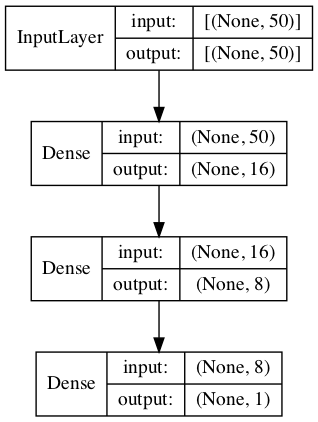

In [89]:
model.summary()
Image(tf.keras.utils.model_to_dot(model,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

In [90]:
# loss, optimizer, metrics 설정
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

In [91]:
# batch size, epoch, 조기종료조건 등 설정
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),]
# keras.callbacks.ModelCheckpoint(filepath='best_nn_model.h5', monitor='val_loss', save_best_only=True)]

hist = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=100, callbacks=callbacks, shuffle=False, verbose=2) #9015

Epoch 1/100
1160/1160 - 3s - loss: 0.3683 - acc: 0.8345 - auc_22: 0.9102 - val_loss: 0.3456 - val_acc: 0.8458 - val_auc_22: 0.9215 - 3s/epoch - 3ms/step
Epoch 2/100
1160/1160 - 2s - loss: 0.3432 - acc: 0.8458 - auc_22: 0.9225 - val_loss: 0.3415 - val_acc: 0.8466 - val_auc_22: 0.9232 - 2s/epoch - 1ms/step
Epoch 3/100
1160/1160 - 2s - loss: 0.3398 - acc: 0.8466 - auc_22: 0.9239 - val_loss: 0.3388 - val_acc: 0.8471 - val_auc_22: 0.9243 - 2s/epoch - 1ms/step
Epoch 4/100
1160/1160 - 2s - loss: 0.3377 - acc: 0.8470 - auc_22: 0.9247 - val_loss: 0.3371 - val_acc: 0.8475 - val_auc_22: 0.9249 - 2s/epoch - 1ms/step
Epoch 5/100
1160/1160 - 2s - loss: 0.3363 - acc: 0.8474 - auc_22: 0.9252 - val_loss: 0.3360 - val_acc: 0.8478 - val_auc_22: 0.9254 - 2s/epoch - 1ms/step
Epoch 6/100
1160/1160 - 2s - loss: 0.3353 - acc: 0.8477 - auc_22: 0.9256 - val_loss: 0.3350 - val_acc: 0.8480 - val_auc_22: 0.9258 - 2s/epoch - 1ms/step
Epoch 7/100
1160/1160 - 2s - loss: 0.3344 - acc: 0.8481 - auc_22: 0.9260 - val_los

In [92]:
y_pred = model.predict(X_dev)
auc = roc_auc_score(y_dev, y_pred)
DNN_tunned.append((type(model).__name__+"3",model,auc))
print(auc)

0.9291453018672132


In [93]:
#with open('DNN_2.pkl', 'wb') as f:
    #pickle.dump(model, f)

# model = pd.read_pickle('nn_model.pkl')

INFO:tensorflow:Assets written to: ram://e0c1e5d6-897e-4943-b053-7bd17effa6bd/assets


### DNN 2-1

In [94]:
import keras
input = keras.Input(shape=(X_train.shape[1],))

x = keras.layers.Dense(32, activation='relu')(input) # 은닉층 낮추기
x = keras.layers.Dense(16, activation='relu')(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(input, output)

model.summary()

#Image(keras.utils.model_to_dot(DEEP,show_shapes=True,show_layer_names=False, dpi=100).create(prog='dot', format='png'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5),] # patience 낮추기

hist = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=15, callbacks=callbacks, shuffle=False, verbose=2)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_67 (Dense)            (None, 32)                1632      
                                                                 
 dense_68 (Dense)            (None, 16)                528       
                                                                 
 dense_69 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1160/1160 - 3s - loss: 0.3625 - acc: 0.8357 - auc_23: 0.9132 - val_loss: 0.3427 - val_acc: 0.8470 - val_auc_23: 0.9228 - 3s/epoch - 2ms/step
Epoch 2/15
1160/1160 - 2s - loss: 0.

In [95]:
y_pred = model.predict(X_dev)
auc = roc_auc_score(y_dev, y_pred)
DNN_tunned.append((type(model).__name__+"4",model,auc))
print(auc)

0.9292471039996464


In [96]:
#with open('DNN_2-1.pkl', 'wb') as f:
    #pickle.dump(model, f)

# model = pd.read_pickle('nn_model.pkl')

INFO:tensorflow:Assets written to: ram://6b7d3763-c6d7-4eee-b4a0-a3da10db3ba8/assets


### DNN TUNE

In [97]:
def model_fn(hp):
    inputs = keras.Input(shape=(X_train.shape[1],))
    x = inputs
    for i in range(hp.Int('num_layers', 2, 3)):
        x = keras.layers.Dense(hp.Int('unit_'+str(i), 16, 64, step=16), activation='relu')(x)
        x = keras.layers.Dropout(hp.Float('dropout_'+str(i), 0, 0.5, step=0.25, default=0.5))(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                  metrics=[keras.metrics.AUC()])
    return model 

In [98]:
tuner = kt.Hyperband(model_fn,
                     objective=kt.Objective('val_auc', direction="max"), 
                     max_epochs=5,
                     hyperband_iterations=2,
                     overwrite=True,
                     directory='dnn_tuning')

tuner.search(X_train, y_train, validation_data=(X_dev, y_dev), 
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

model = tuner.get_best_models(1)[0]
model.summary()

Trial 20 Complete [00h 02m 55s]
val_auc: 0.9236010313034058

Best val_auc So Far: 0.9282618761062622
Total elapsed time: 00h 49m 38s
INFO:tensorflow:Oracle triggered exit
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 48)                2448      
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                784       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)      

In [99]:
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),]
hist = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                 batch_size=1024, epochs=50, callbacks=callbacks, shuffle=False, verbose=2)

Epoch 1/50
1160/1160 - 3s - loss: 0.3666 - auc_1: 0.9111 - val_loss: 0.3392 - val_auc_1: 0.9240 - 3s/epoch - 3ms/step
Epoch 2/50
1160/1160 - 2s - loss: 0.3446 - auc_1: 0.9218 - val_loss: 0.3354 - val_auc_1: 0.9257 - 2s/epoch - 2ms/step
Epoch 3/50
1160/1160 - 2s - loss: 0.3412 - auc_1: 0.9234 - val_loss: 0.3331 - val_auc_1: 0.9266 - 2s/epoch - 2ms/step
Epoch 4/50
1160/1160 - 2s - loss: 0.3394 - auc_1: 0.9242 - val_loss: 0.3315 - val_auc_1: 0.9273 - 2s/epoch - 2ms/step
Epoch 5/50
1160/1160 - 2s - loss: 0.3378 - auc_1: 0.9249 - val_loss: 0.3304 - val_auc_1: 0.9278 - 2s/epoch - 2ms/step
Epoch 6/50
1160/1160 - 2s - loss: 0.3370 - auc_1: 0.9253 - val_loss: 0.3298 - val_auc_1: 0.9281 - 2s/epoch - 2ms/step
Epoch 7/50
1160/1160 - 3s - loss: 0.3360 - auc_1: 0.9257 - val_loss: 0.3290 - val_auc_1: 0.9284 - 3s/epoch - 2ms/step
Epoch 8/50
1160/1160 - 2s - loss: 0.3355 - auc_1: 0.9260 - val_loss: 0.3284 - val_auc_1: 0.9286 - 2s/epoch - 2ms/step
Epoch 9/50
1160/1160 - 2s - loss: 0.3348 - auc_1: 0.9263

In [100]:
y_pred = model.predict(X_dev)
auc = roc_auc_score(y_dev, y_pred)
DNN_tunned.append((type(model).__name__+"5",model,auc))
print(auc)

0.9307068294181939


In [101]:
#with open('DNN_TUNE.pkl', 'wb') as f:
    #pickle.dump(model, f)

# model = pd.read_pickle('nn_model.pkl')

INFO:tensorflow:Assets written to: ram://d249b55b-134e-48da-928d-ae982c76f5b7/assets


### DNN ENSEMBLE

In [102]:
selected = ['Functional1', 'Functional2', 'Functional3', 'Functional4', 'Functional5']
models_for_ensemble = [(clf[0], clf[1]) for clf in DNN_tunned if clf[0] in selected]

In [103]:
avg_clf = AveragingClassifier(models_for_ensemble, 1)

# Averaging ensemble로 예측한 submission: 
pd.DataFrame({'ID': test_id["ID"], 'STATUS': avg_clf.predict_proba(test)}).to_csv('submission_dnn_semi_FINAL.csv', index=False)

In [104]:
#with open('DNN_ENSEMBLE.pkl', 'wb') as f:
    #pickle.dump(avg_clf, f)

# model = pd.read_pickle('nn_model.pkl')

INFO:tensorflow:Assets written to: ram://273682af-c60e-4939-bd9c-85126851b469/assets
INFO:tensorflow:Assets written to: ram://cee75272-421e-4b65-b3aa-2eea347d158b/assets
INFO:tensorflow:Assets written to: ram://f7eb8b9c-dd17-4c7b-91bb-ef7eaab3bbea/assets
INFO:tensorflow:Assets written to: ram://a2e67cfd-7567-4d28-93fb-24e1c3e83d24/assets
INFO:tensorflow:Assets written to: ram://4bd6d742-9099-43cd-9e48-e64dc425ffc3/assets


### LGBM MODEL

In [12]:
from lightgbm import LGBMClassifier

lgbm_wrapper = LGBMClassifier(n_estimators = 100,random_state=42) # 400번 학습

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", 
                 eval_set=evals, verbose=False)
lgbm_pred_proba = lgbm_wrapper.predict_proba(X_dev)[:,1]

In [13]:
score=roc_auc_score(y_dev,lgbm_pred_proba)
print(score)

0.932505533707127


In [14]:
ensemble100= BaggingClassifier(base_estimator=lgbm_wrapper,n_estimators=100,n_jobs=-1,max_samples=0.5,max_features=0.5,random_state=1).fit(X_train1,y_train1)
y_pred = ensemble100.predict_proba(X_dev1)[:,1]
auc = roc_auc_score(y_dev1, y_pred)
print(auc)
lgbm_tunned=[]
lgbm_tunned.append((type(ensemble100).__name__+"BAG1",ensemble100,auc))

0.9250307806763991


In [15]:
#with open('LGBM_BAGGING_100.pkl', 'wb') as f:
    #pickle.dump(ensemble100, f)

# model = pd.read_pickle('nn_model.pkl')

In [16]:
ensemble200= BaggingClassifier(base_estimator=lgbm_wrapper,n_estimators=200,n_jobs=-1,max_samples=0.7,max_features=0.7,random_state=1).fit(X_train,y_train)
y_pred = ensemble200.predict_proba(X_dev)[:,1]
auc = roc_auc_score(y_dev, y_pred)
print(auc)
lgbm_tunned.append((type(ensemble200).__name__+"BAG2",ensemble200,auc))

0.9308083599063799


In [17]:
#with open('LGBM_BAGGING_200.pkl', 'wb') as f:
    #pickle.dump(ensemble200, f)

# model = pd.read_pickle('nn_model.pkl')

### LGBM TUNE MODEL

In [18]:
pbounds = {
    'n_estimators':(50,800),
    'learning_rate':(0.001,1.5),
    'max_depth':(2, 32),
    'num_leaves':(2, 64),
    'subsample':(0.5, 0.95),
    'colsample_bytree':(0.5, 0.95),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 50),
    'reg_alpha':(0.001, 50)
}
def lgbm_opt(n_estimators, learning_rate, max_depth, num_leaves,
             subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)), 
        "learning_rate":learning_rate,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
        'max_bin':int(max_bin)
    }
    

    lgbm = LGBMClassifier(random_state=0, **params, n_jobs=-1)
    lgbm.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=evals, verbose=False)
    score = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)
 
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=0)
BO_lgbm.maximize(init_points=10, n_iter=10)

max_params_lgbm = BO_lgbm.max['params']
max_params_lgbm

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9314   |  0.747    |  1.073    |  305.4    |  18.35    |  367.7    |  42.05    |  21.88    |  44.59    |  0.9336   |
|  2        |  0.8753   |  0.6725   |  1.188    |  269.2    |  19.04    |  744.2    |  6.404    |  4.357    |  1.012    |  0.8747   |
|  3        |  0.9279   |  0.8502   |  1.305    |  489.5    |  25.97    |  396.1    |  50.39    |  5.915    |  32.0     |  0.5645   |
|  4        |  0.9347   |  0.9251   |  0.7833   |  213.2    |  9.937    |  630.7    |  30.28    |  28.42    |  0.9405   |  0.7779   |
|  5        |  0.9322   |  0.7754   |  0.9258   |  472.4    |  22.45    |  319.6    |  29.1     |  34.88    |  3.012    |  0.8      |
|  6        |  0.9352   |  0.8018   |  0.3164   |  73.17    | 

{'colsample_bytree': 0.9306244122771947,
 'learning_rate': 0.37230566495040346,
 'max_bin': 77.89113076713795,
 'max_depth': 31.897645770714107,
 'n_estimators': 209.55246018624374,
 'num_leaves': 43.236184657090035,
 'reg_alpha': 0.8727552768281859,
 'reg_lambda': 33.92309149823117,
 'subsample': 0.8753884223526035}

In [19]:
max_params_lgbm['n_estimators'] = int(max_params_lgbm['n_estimators'])
max_params_lgbm['max_depth'] = int(max_params_lgbm['max_depth'])
max_params_lgbm['max_bin'] = int(max_params_lgbm['max_bin'])
max_params_lgbm['num_leaves'] = int(max_params_lgbm['num_leaves'])

In [20]:
lgbm_clf = LGBMClassifier(random_state = 0, **max_params_lgbm)

In [21]:
lgbm_clf.fit(X_train,y_train)
y_pred = lgbm_clf.predict_proba(X_dev)[:,1]
auc = roc_auc_score(y_dev, y_pred)
print(auc)

0.9365298398937879


In [22]:
#with open('LGBM_TUNE.pkl', 'wb') as f:
    #pickle.dump(lgbm_clf, f)

# model = pd.read_pickle('nn_model.pkl')

### LGBM_3 BAGGING CLASSIFER

In [23]:
ensemble300= BaggingClassifier(base_estimator=lgbm_clf,n_estimators=100,n_jobs=-1,max_samples=0.5,max_features=0.5,random_state=1).fit(X_train1,y_train1)

y_pred = ensemble300.predict_proba(X_dev1)[:,1]
auc = roc_auc_score(y_dev1, y_pred)
print(auc)
lgbm_tunned.append((type(ensemble300).__name__+"BAG3",ensemble300,auc))

0.931399171695781


In [24]:
#with open('LGBM_BAGGING_300.pkl', 'wb') as f:
    #pickle.dump(ensemble300, f)

# model = pd.read_pickle('nn_model.pkl')

### LGBM_4 BAGGING CLASSIFER

In [25]:
ensemble400= BaggingClassifier(base_estimator=lgbm_clf,n_estimators=200,n_jobs=-1,max_samples=0.7,max_features=0.7,random_state=1).fit(X_train,y_train)

y_pred = ensemble400.predict_proba(X_dev)[:,1]
auc = roc_auc_score(y_dev, y_pred)
print(auc)
lgbm_tunned.append((type(ensemble400).__name__+"BAG4",ensemble400,auc))

0.9359399573708297


In [26]:
#with open('LGBM_BAGGING_400.pkl', 'wb') as f:
    #pickle.dump(ensemble400, f)

# model = pd.read_pickle('nn_model.pkl')

### LGBM ENSEMBLE

In [50]:
selected = ['BaggingClassifierBAG1', 'BaggingClassifierBAG2', 'BaggingClassifierBAG3', 'BaggingClassifierBAG4']
models_for_ensemble = [(clf[0], clf[1]) for clf in lgbm_tunned if clf[0] in selected]

avg_clf_lgbm = AveragingClassifier(models_for_ensemble, 1.5)
avg_clf_lgbm.fit(X_train, y_train)
# Averaging ensemble로 예측한 submission: 
pd.DataFrame({'ID': test_id["ID"], 'STATUS': avg_clf_lgbm.predict_proba(test)}).to_csv('submission_lgbm_semi_FINAL.csv', index=False)

In [28]:
#with open('LGBM_ENSEMBLE.pkl', 'wb') as f:
    #pickle.dump(avg_clf_lgbm, f)

# model = pd.read_pickle('nn_model.pkl')

### lr 모델

In [29]:
def lr_opt(trial):
    lr_penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", "none"])
    lr_c = trial.suggest_float("C", 0.01, 10, step = 0.05)
    
    lr_clf = LogisticRegression(
            penalty = lr_penalty,
            C = lr_c,
            n_jobs = -1,
            random_state = 44
    )
    
    score = np.mean(cross_val_score(lr_clf, X_train, y_train, scoring = "roc_auc", n_jobs = -1))
    return score

study = optuna.create_study(direction="maximize")
study.optimize(lr_opt, n_trials=20)

[I 2021-12-14 10:42:02,237] A new study created in memory with name: no-name-f7cd19eb-7455-40fa-b867-27def0c7f588
[W 2021-12-14 10:42:04,456] Trial 0 failed, because the objective function returned nan.
[W 2021-12-14 10:42:05,780] Trial 1 failed, because the objective function returned nan.
[W 2021-12-14 10:42:07,307] Trial 2 failed, because the objective function returned nan.
[W 2021-12-14 10:42:08,675] Trial 3 failed, because the objective function returned nan.
/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/User

In [30]:
lr_clf=LogisticRegression(**study.best_trial.params)
lr_clf.fit(X_train,y_train)

LogisticRegression(C=0.41000000000000003)

In [31]:
#with open('LR_model.pkl', 'wb') as f:
    #pickle.dump(lr_clf, f)

# model = pd.read_pickle('nn_model.pkl')

### LR BAGGING CLASSIFIER

In [32]:
ensemble100= BaggingClassifier(base_estimator=lr_clf,n_estimators=100,n_jobs=-1,max_samples=0.5,max_features=0.5,random_state=1).fit(X_train1,y_train1)

y_pred = ensemble100.predict_proba(X_dev1)[:,1]
auc = roc_auc_score(y_dev1, y_pred)
print(auc)
lr_tunned=[]
lr_tunned.append((type(ensemble100).__name__+"BAG1",ensemble100,auc))

/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jody/opt

0.907619768897483


In [33]:
#with open('LR_BAGGING.pkl', 'wb') as f:
    #pickle.dump(ensemble100, f)

# model = pd.read_pickle('nn_model.pkl')

In [34]:
ensemble200= BaggingClassifier(base_estimator=lr_clf,n_estimators=200,n_jobs=-1,max_samples=0.7,max_features=0.7,random_state=1).fit(X_train,y_train)

y_pred = ensemble200.predict_proba(X_dev)[:,1]
auc = roc_auc_score(y_dev, y_pred)
print(auc)
lr_tunned.append((type(ensemble200).__name__+"BAG2",ensemble200,auc))

/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

0.9141713692885309


In [35]:
#with open('LR_BAGGING_2.pkl', 'wb') as f:
    #pickle.dump(ensemble200, f)

# model = pd.read_pickle('nn_model.pkl')

### LR model2 (LinearDiscriminantAnalysis)

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [37]:
def lda_clf(trial):
    lda_solver = trial.suggest_categorical("solver", ['svd', 'lsqr', 'eigen'])
   
    lda_clf = LinearDiscriminantAnalysis(
            solver = lda_solver)
    
    score = np.mean(cross_val_score(lda_clf, X_train, y_train, scoring = "roc_auc", n_jobs = -1))
    return score

study = optuna.create_study(direction="maximize")
study.optimize(lda_clf, n_trials=20)

[I 2021-12-14 11:18:46,922] A new study created in memory with name: no-name-7816d649-f381-4f3e-ae2e-2259da263a3c
/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py", line 468, in fit
    self._solve_eigen(X, y, shrinkage=self.shrinkage)
  File "/Users/jody/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py", line 335, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/Users/jody/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp.py", line 578, in eigh
    rai

In [38]:
ld_clf=LinearDiscriminantAnalysis(**study.best_trial.params)
ld_clf.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [39]:
#with open('LR_model_2.pkl', 'wb') as f:
    #pickle.dump(ld_clf, f)

# model = pd.read_pickle('nn_model.pkl')

### LR BAGGING2

In [40]:
ensemble300= BaggingClassifier(base_estimator=ld_clf,n_estimators=100,n_jobs=-1,max_samples=0.5,max_features=0.5,random_state=1).fit(X_train1,y_train1)

y_pred = ensemble300.predict_proba(X_dev1)[:,1]
auc = roc_auc_score(y_dev1, y_pred)
print(auc)
lr_tunned.append((type(ensemble300).__name__+"BAG3",ensemble300,auc))

0.9064251354296767


In [41]:
#with open('LDR_BAGGING_1.pkl', 'wb') as f:
    #pickle.dump(ensemble300, f)

# model = pd.read_pickle('nn_model.pkl')

In [42]:
ensemble400= BaggingClassifier(base_estimator=ld_clf,n_estimators=200,n_jobs=-1,max_samples=0.7,max_features=0.7,random_state=1).fit(X_train,y_train)

y_pred = ensemble400.predict_proba(X_dev)[:,1]
auc = roc_auc_score(y_dev, y_pred)
print(auc)
lr_tunned.append((type(ensemble400).__name__+"BAG4",ensemble400,auc))

0.9129753085523221


In [43]:
#with open('LDR_BAGGING_2.pkl', 'wb') as f:
    #pickle.dump(ensemble400, f)

# model = pd.read_pickle('nn_model.pkl')

### LR ENSEMBLE

In [47]:
selected = ['BaggingClassifierBAG1', 'BaggingClassifierBAG2', 'BaggingClassifierBAG3', 'BaggingClassifierBAG4']
models_for_ensemble = [(clf[0], clf[1]) for clf in lr_tunned if clf[0] in selected]

avg_clf_lr = AveragingClassifier(models_for_ensemble, 1)
avg_clf_lr.fit(X_train, y_train)

# Averaging ensemble로 예측한 submission: 
pd.DataFrame({'ID': test_id["ID"], 'STATUS': avg_clf_lr.predict_proba(test)}).to_csv('submission_LR_semi_FINAL.csv', index=False)

In [ ]:
#with open('LR_ENSEMBLE.pkl', 'wb') as f:
    #pickle.dump(avg_clf_lr, f)

# model = pd.read_pickle('nn_model.pkl')

### catboost model

In [51]:
c_model = CatBoostClassifier(random_state = 44)
c_model.fit(X_train,y_train)
pred=c_model.predict_proba(X_dev)
score=roc_auc_score(y_dev,pred[:,1])
print("CatBoostClassifier", c_model, score)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.211762
0:	learn: 0.5312695	total: 101ms	remaining: 1m 40s
1:	learn: 0.4541751	total: 191ms	remaining: 1m 35s
2:	learn: 0.4068831	total: 304ms	remaining: 1m 40s
3:	learn: 0.3826985	total: 412ms	remaining: 1m 42s
4:	learn: 0.3698501	total: 500ms	remaining: 1m 39s
5:	learn: 0.3577399	total: 585ms	remaining: 1m 36s
6:	learn: 0.3534137	total: 671ms	remaining: 1m 35s
7:	learn: 0.3486169	total: 757ms	remaining: 1m 33s
8:	learn: 0.3461931	total: 847ms	remaining: 1m 33s
9:	learn: 0.3427937	total: 953ms	remaining: 1m 34s
10:	learn: 0.3412178	total: 1.07s	remaining: 1m 36s
11:	learn: 0.3398412	total: 1.17s	remaining: 1m 36s
12:	learn: 0.3388486	total: 1.26s	remaining: 1m 35s
13:	learn: 0.3378839	total: 1.35s	remaining: 1m 35s
14:	learn: 0.3365937	total: 1.45s	remaining: 1m 35s
15:	learn: 0.3356321	total: 1.57s	remaining: 1m 36s
16:	learn: 0.3350192	total: 1.68s	remaining: 1m 36s
17:	learn: 0.3338677	total: 1.77s	remaining: 1m 36s
18:	learn: 0.3333285	total: 1.86s	remaining:

In [52]:
#with open('catboost.pkl', 'wb') as f:
    #pickle.dump(c_model, f)

# model = pd.read_pickle('nn_model.pkl')

### CAT BAGGING 1

In [53]:
ensemble100= BaggingClassifier(base_estimator=c_model,n_estimators=20,n_jobs=-1,max_samples=0.5,max_features=0.5,random_state=1).fit(X_train1,y_train1)

y_pred = ensemble100.predict_proba(X_dev1)[:,1]
auc = roc_auc_score(y_dev1, y_pred)
print(auc)
cat_tunned=[]
cat_tunned.append((type(ensemble100).__name__+"BAG1",ensemble100,auc))

Learning rate set to 0.22617
0:	learn: 0.5895663	total: 1.47s	remaining: 24m 29s
1:	learn: 0.5334057	total: 2.75s	remaining: 22m 49s
2:	learn: 0.5007494	total: 4.09s	remaining: 22m 40s
3:	learn: 0.4798392	total: 5.49s	remaining: 22m 47s
4:	learn: 0.4666860	total: 6.73s	remaining: 22m 19s
5:	learn: 0.4586067	total: 8.14s	remaining: 22m 29s
6:	learn: 0.4513422	total: 9.76s	remaining: 23m 4s
7:	learn: 0.4473789	total: 11s	remaining: 22m 44s
8:	learn: 0.4441442	total: 12.2s	remaining: 22m 23s
9:	learn: 0.4419264	total: 13.5s	remaining: 22m 19s
10:	learn: 0.4402444	total: 15.1s	remaining: 22m 37s
11:	learn: 0.4386560	total: 16.7s	remaining: 22m 52s
12:	learn: 0.4374343	total: 18.2s	remaining: 23m 3s
13:	learn: 0.4362197	total: 19.5s	remaining: 22m 51s
14:	learn: 0.4349790	total: 21.2s	remaining: 23m 11s
15:	learn: 0.4339301	total: 22.8s	remaining: 23m 19s
16:	learn: 0.4331143	total: 24s	remaining: 23m 6s
17:	learn: 0.4320806	total: 25.2s	remaining: 22m 54s
18:	learn: 0.4313897	total: 26.6s	

In [54]:
#with open('CAT_BAGGING_1.pkl', 'wb') as f:
    #pickle.dump(ensemble100, f)

# model = pd.read_pickle('nn_model.pkl')

In [55]:
ensemble200= BaggingClassifier(base_estimator=c_model,n_estimators=40,n_jobs=-1,max_samples=0.7,max_features=0.7,random_state=1).fit(X_train,y_train)

y_pred = ensemble200.predict_proba(X_dev)[:,1]
auc = roc_auc_score(y_dev, y_pred)
print(auc)
cat_tunned.append((type(ensemble200).__name__+"BAG2",ensemble200,auc))

816:	learn: 0.3016754	total: 4m 58s	remaining: 1m 6s
817:	learn: 0.3016629	total: 4m 58s	remaining: 1m 6s
818:	learn: 0.3016424	total: 4m 59s	remaining: 1m 6s
819:	learn: 0.3016252	total: 4m 59s	remaining: 1m 5s
820:	learn: 0.3016012	total: 5m	remaining: 1m 5s
821:	learn: 0.3015897	total: 5m	remaining: 1m 5s
822:	learn: 0.3015598	total: 5m 1s	remaining: 1m 4s
823:	learn: 0.3015494	total: 5m 1s	remaining: 1m 4s
824:	learn: 0.3015244	total: 5m 1s	remaining: 1m 4s
825:	learn: 0.3015077	total: 5m 2s	remaining: 1m 3s
826:	learn: 0.3014905	total: 5m 2s	remaining: 1m 3s
827:	learn: 0.3014735	total: 5m 3s	remaining: 1m 2s
828:	learn: 0.3014641	total: 5m 3s	remaining: 1m 2s
829:	learn: 0.3014400	total: 5m 3s	remaining: 1m 2s
830:	learn: 0.3013865	total: 5m 4s	remaining: 1m 1s
831:	learn: 0.3013696	total: 5m 4s	remaining: 1m 1s
832:	learn: 0.3013466	total: 5m 4s	remaining: 1m 1s
833:	learn: 0.3013294	total: 5m 5s	remaining: 1m
834:	learn: 0.3013112	total: 5m 5s	remaining: 1m
835:	learn: 0.301299

In [56]:
#with open('CAT_BAGGING_2.pkl', 'wb') as f:
    #pickle.dump(ensemble200, f)

# model = pd.read_pickle('nn_model.pkl')

### CAT ENSEMBLE

In [57]:
selected = ['BaggingClassifierBAG1', 'BaggingClassifierBAG2']
models_for_ensemble = [(clf[0], clf[1]) for clf in cat_tunned if clf[0] in selected]

avg_clf_CAT = AveragingClassifier(models_for_ensemble, 1)
avg_clf_CAT.fit(X_train, y_train)

# Averaging ensemble로 예측한 submission: 
pd.DataFrame({'ID': test_id["ID"], 'STATUS': avg_clf_CAT.predict_proba(test)}).to_csv('submission_CAT_semi_FINAL.csv', index=False)

In [58]:
#with open('CAT_ENSEMBLE.pkl', 'wb') as f:
    #pickle.dump(avg_clf_CAT, f)

# model = pd.read_pickle('nn_model.pkl')

### ADABOOST

In [59]:
pbounds = { 'learning_rate': (0.01, 1.5),
            'n_estimators': (50, 100)}

def ada_opt(learning_rate, n_estimators):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators))
    }
    
    ada = AdaBoostClassifier(**params,random_state=0,)
    score = cross_val_score(ada, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)
    return np.mean(score)

BO_ada = BayesianOptimization(f = ada_opt, pbounds = pbounds, random_state=0)
BO_ada.maximize(init_points=10, n_iter=10)

max_params_ada = BO_ada.max['params']
max_params_ada

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
|  1        |  0.9222   |  0.8277   |  85.76    |
|  2        |  0.9222   |  0.9081   |  77.24    |
|  3        |  0.9215   |  0.6412   |  82.29    |
|  4        |  0.9219   |  0.662    |  94.59    |
|  5        |  0.9226   |  1.446    |  69.17    |
|  6        |  0.9229   |  1.19     |  76.44    |
|  7        |  0.9226   |  0.8564   |  96.28    |
|  8        |  0.9169   |  0.1158   |  54.36    |
|  9        |  0.9123   |  0.04013  |  91.63    |
|  10       |  0.9232   |  1.169    |  93.5     |
|  11       |  0.8876   |  0.01     |  75.28    |
|  12       |  0.9234   |  1.479    |  95.44    |
|  13       |  0.9223   |  0.8773   |  84.1     |
|  14       |  0.9214   |  0.7712   |  67.64    |
|  15       |  0.8865   |  0.01     |  69.77    |
|  16       |  0.9073   |  0.02657  |  84.79    |
|  17       |  0.9234   |  1.491    |  94.46    |
|  18       |  0.9231   |  1.491    |  83.21    |


{'learning_rate': 1.491323457585711, 'n_estimators': 94.45675868374451}

In [60]:
max_params_ada['n_estimators'] = int(max_params_ada['n_estimators'])
ada_clf = AdaBoostClassifier(random_state = 0, **max_params_ada)
ada_clf.fit(X_train,y_train)

y_pred=ada_clf.predict_proba(X_dev)[:,1]
auc=roc_auc_score(y_dev,y_pred)

In [61]:
#with open('ADABOOST.pkl', 'wb') as f:
    #pickle.dump(ada_clf, f)

# model = pd.read_pickle('nn_model.pkl')

### ADA BAGGING1

In [62]:
ensemble100= BaggingClassifier(base_estimator=ada_clf,n_estimators=100,n_jobs=-1,max_samples=0.5,max_features=0.5,random_state=1).fit(X_train1,y_train1)

y_pred = ensemble100.predict_proba(X_dev1)[:,1]
auc = roc_auc_score(y_dev1, y_pred)
print(auc)
ADA_tunned=[]
ADA_tunned.append((type(ensemble100).__name__+"BAG1",ensemble100,auc))

0.9167509389612899


In [63]:
#with open('ADA_BAGGING_1.pkl', 'wb') as f:
    #pickle.dump(ensemble100, f)

# model = pd.read_pickle('nn_model.pkl')

In [65]:
ensemble200= BaggingClassifier(base_estimator=ada_clf,n_estimators=200,n_jobs=-1,max_samples=0.7,max_features=0.7,random_state=1).fit(X_train,y_train)

y_pred = ensemble200.predict_proba(X_dev)[:,1]
auc = roc_auc_score(y_dev, y_pred)
print(auc)

ADA_tunned.append((type(ensemble200).__name__+"BAG2",ensemble200,auc))

0.9219200120628349


In [66]:
#with open('ADA_BAGGING_2.pkl', 'wb') as f:
    #pickle.dump(ensemble200, f)

# model = pd.read_pickle('nn_model.pkl')

### ADA ENSEMBLE

In [67]:
selected = ['BaggingClassifierBAG1', 'BaggingClassifierBAG2']
models_for_ensemble = [(clf[0], clf[1]) for clf in ADA_tunned if clf[0] in selected]

avg_clf_ADA = AveragingClassifier(models_for_ensemble, 1)
avg_clf_ADA.fit(X_train, y_train)

# Averaging ensemble로 예측한 submission: 
pd.DataFrame({'ID': test_id["ID"], 'STATUS': avg_clf_ADA.predict_proba(test)}).to_csv('submission_ADA_semi_FINAL.csv', index=False)

In [68]:
#with open('ADA_ENSEMBLE.pkl', 'wb') as f:
    #pickle.dump(avg_clf_ADA, f)

# model = pd.read_pickle('nn_model.pkl')

### XGB

In [6]:
pbounds = { 'learning_rate': (0.01, 1.5),
            'n_estimators': (50, 100),
            'max_depth': (5,15),   
            'subsample': (0.8,0.95),   
            'gamma': (0, 5)}

def xgb_opt(learning_rate, n_estimators, max_depth, subsample, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,  
        'gamma': gamma
    }
    
    xgb = XGBClassifier(**params, n_jobs=-1, random_state=0,early_stopping_rounds=10, eval_metric="logloss", eval_set=evals)
    score = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)
    return np.mean(score)

BO_xgb = BayesianOptimization(f = xgb_opt, pbounds = pbounds, random_state=0)
BO_xgb.maximize(init_points=5, n_iter=5)

max_params_xgb = BO_xgb.max['params']
max_params_xgb

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
max_params_xgb['n_estimators'] = int(max_params_xgb['n_estimators'])
max_params_xgb['max_depth'] = int(max_params_xgb['max_depth'])

In [ ]:
xgb_clf = XGBClassifier(random_state = 0, **max_params_xgb)

In [ ]:
#with open('XGB.pkl', 'wb') as f:
    #pickle.dump(xgb_clf, f)

# model = pd.read_pickle('nn_model.pkl')

In [8]:
xgb_clf = pd.read_pickle('XGB.pkl')

### XGB_BAGGING

In [9]:
ensemble200= BaggingClassifier(base_estimator=xgb_clf,n_estimators=50,n_jobs=-1,max_samples=0.7,max_features=0.7,random_state=1).fit(X_train,y_train)

y_pred = ensemble200.predict_proba(X_dev)[:,1]
auc = roc_auc_score(y_dev, y_pred)
print(auc)
XGB_tunned=[]
XGB_tunned.append((type(ensemble200).__name__+"BAG1",ensemble200,auc))

# Averaging ensemble로 예측한 submission: 
pd.DataFrame({'ID': test_id["ID"], 'STATUS': ensemble200.predict_proba(test)[:,1]}).to_csv('submission_XGB_semi_FINAL.csv', index=False)

/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:05:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:34:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:37:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:38:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:07:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:34:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:06:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:06:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:34:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9364112196593194
[06:37:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:06:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:38:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:06:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:04:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:04:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:32:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:38:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:06:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:38:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:07:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:38:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:06:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:37:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [10]:
#with open('XGB_BAGGING_2.pkl', 'wb') as f:
    #pickle.dump(ensemble200, f)

# model = pd.read_pickle('nn_model.pkl')

[06:37:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:05:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:05:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:03:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:03:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:30:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:38:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:09:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:37:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:03:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/jody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### RandomForest

In [84]:
pbounds = { 'n_estimators': (50,250),
            'max_depth': (5,15), 
            'max_features': (0.8,0.95),
            'min_samples_leaf': (1, 5)}

def rf_opt(n_estimators, max_depth, max_features, min_samples_leaf):
    params = {'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'min_samples_leaf' : int(round(min_samples_leaf))}

    rf = RandomForestClassifier(**params, n_jobs = -1, random_state = 0)
    score = cross_val_score(rf, X_train, y_train, scoring = 'roc_auc', cv = 4, n_jobs = -1)
    return np.mean(score)


BO_rf = BayesianOptimization(f = rf_opt, pbounds = pbounds, random_state=0)
BO_rf.maximize(init_points=5, n_iter=5)

max_params_rf = BO_rf.max['params']
max_params_rf

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.9215   |  10.49    |  0.9073   |  3.411    |  159.0    |
|  2        |  0.9187   |  9.237    |  0.8969   |  2.75     |  228.4    |
|  3        |  0.9311   |  14.64    |  0.8575   |  4.167    |  155.8    |
|  4        |  0.9237   |  10.68    |  0.9388   |  1.284    |  67.43    |
|  5        |  0.9007   |  5.202    |  0.9249   |  4.113    |  224.0    |
|  6        |  0.9279   |  13.09    |  0.8484   |  3.961    |  152.5    |
|  7        |  0.9311   |  14.84    |  0.8232   |  1.167    |  144.8    |
|  8        |  0.9294   |  13.91    |  0.8801   |  4.619    |  139.1    |
|  9        |  0.906    |  6.297    |  0.9248   |  1.433    |  142.2    |
|  10       |  0.9309   |  14.57    |  0.8936   |  4.772    |  145.1    |


{'max_depth': 14.837365893767457,
 'max_features': 0.8232224130822806,
 'min_samples_leaf': 1.1667650886545045,
 'n_estimators': 144.8015995338499}

In [85]:
max_params_rf['n_estimators'] = int(max_params_rf['n_estimators'])
max_params_rf['max_depth'] = int(max_params_rf['max_depth'])
max_params_rf['min_samples_leaf'] = int(max_params_rf['min_samples_leaf'])
rf_clf = RandomForestClassifier(random_state = 0, **max_params_rf)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=14, max_features=0.8232224130822806,
                       n_estimators=144, random_state=0)

In [86]:
#with open('RF.pkl', 'wb') as f:
    #pickle.dump(rf_clf, f)

# model = pd.read_pickle('nn_model.pkl')

In [13]:
rf_clf = pd.read_pickle('RF.pkl')

### RANDOM _FOREST BAGGING

In [14]:
ensemble100= BaggingClassifier(base_estimator=rf_clf,n_estimators=10,n_jobs=-1,max_samples=0.7,max_features=0.7,random_state=1).fit(X_train,y_train)

y_pred = ensemble100.predict_proba(X_dev)[:,1]
auc = roc_auc_score(y_dev, y_pred)
print(auc)
RF_tunned=[]
RF_tunned.append((type(ensemble100).__name__+"BAG1",ensemble100,auc))

# Averaging ensemble로 예측한 submission:
pd.DataFrame({'ID': test_id["ID"], 'STATUS': ensemble100.predict_proba(test)[:,1]}).to_csv('submission_RF_semi_FINAL.csv', index=False)

0.9332945238797893


In [15]:
#with open('RF_BAGGING.pkl', 'wb') as f:
    #pickle.dump(ensemble100, f)

# model = pd.read_pickle('nn_model.pkl')

## MODEL ENSEMBLE

- 단일 모델들 앙상블 분류

pred_results = []
for name, clf, clf_score in clfs_tunned:
    if 'Functional' in name:
        pred = clf.predict(X_dev).flatten()
    else:
        pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (12,8))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

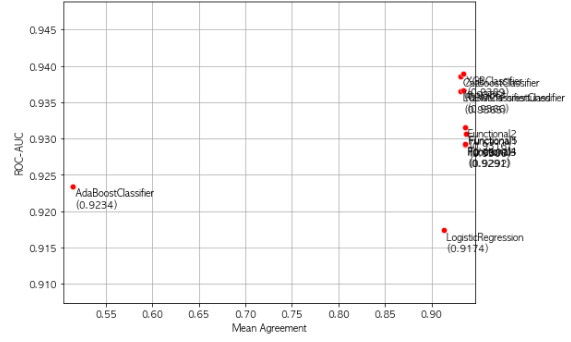

In [ ]:
selected = [
    #'Functional1', 
    #'Functional2',
    #'Functional3', 
    #'Functional4', 
    'Functional5', 
    'LGBMClassifiertuned',
    'LogisticRegression',
    'CatBoostClassifier',
    'AdaBoostClassifier',
    'XGBClassifier',
    'RandomForestClassifier']
models_for_ensemble = [clf for clf in clfs_tunned if clf[0] in selected]

In [ ]:
# 가중평균도 해볼것..?? 가중치를 어캐 둬야 할까?
max_score = 0
for p in tqdm_notebook([0, 1, 1.5]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict(X_dev).flatten()  if "Functional" in name  else clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds =[clf.predict(X_dev).flatten()  if "Functional" in name  else clf.predict_proba(X_dev)[:,1] for name, clf,_ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score
            print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))
    p, models, score = best_avg_ensemble
    print('p={}\n{}\n{}good'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))
p, models, score = best_avg_ensemble
print('p={}\n{}\n{}best'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

단일 모델들에 대해서 시도

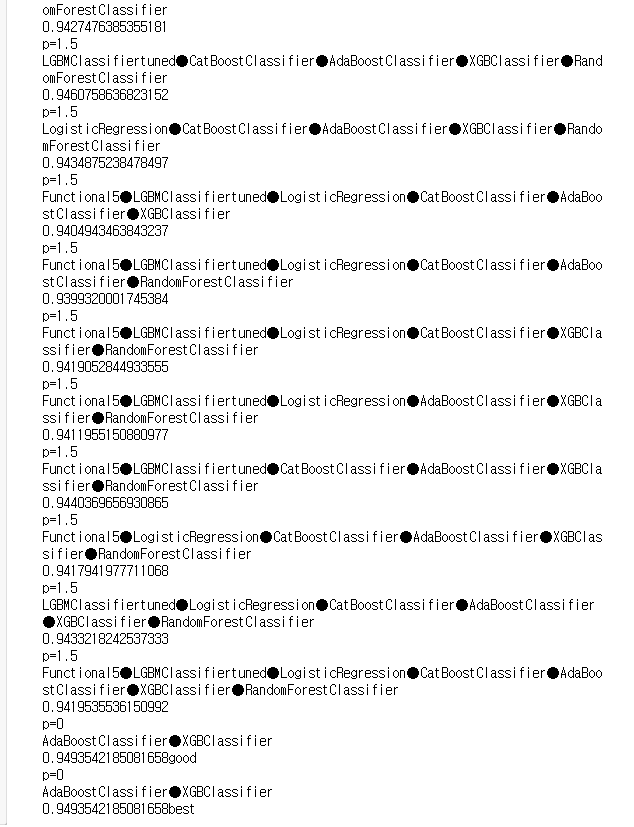

selected = [
    #'Functional1', 
    #'Functional2',
    #'Functional3', 
    #'Functional4', 
    'Functional5', 
    'LGBMClassifiertuned',
    'LogisticRegression',
    'CatBoostClassifier',
    'AdaBoostClassifier',
    'XGBClassifier',
    'RandomForestClassifier']
models_for_ensemble = [(clf[0], clf[1]) for clf in clfs_tunned if clf[0] in selected]

# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def f_fit(self, X, y):
        for i in self.estimators:
            i[1].fit(X,y)
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in self.estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in self.estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict(X).flatten()  if "Functional" in name  else clf.predict_proba(X)[:,1] for name, clf  in self.estimators], axis=0)
        else:
            probs = [clf.predict(X).flatten()  if "Functional" in name  else clf.predict_proba(X)[:,1] for name, clf  in self.estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return prob

    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(models_for_ensemble, 1)# models_for_ensemble 을 estimators자리에 바꿔줘야 함  p 도 상황에 맞춰서 바꿀 것. 
avg_clf.f_fit(train, y_train_all) 

#### Averaging ensemble로 예측한 submission: 
pd.DataFrame({'ID': test_id["ID"], 'STATUS': avg_clf.predict_proba(test)}).to_csv('submission_FINAL6.csv', index=False)

#with open('Aver_Ensem.pkl', 'wb') as f:
    #pickle.dump(avg_clf, f)

#### model = pd.read_pickle('nn_model.pkl')

# SUBMISSION ENSEMBLE

In [3]:
rank_1=pd.read_csv("1st_submission.csv")
rank_2=pd.read_csv("2nd_submission.csv")
rank_3=pd.read_csv("3rd_submission.csv")
rank_123=pd.read_csv("123_rankfinal_submissions.csv")
CV_LGBM=pd.read_csv("submission_semi_FINAL.csv")
diff_LGBM=pd.read_csv("submission_lgbm_semi_diff_FINAL.csv")
Ensemble_model=pd.read_csv("ENSEMBLE_MODEL.csv")
BEST_model=pd.read_csv("best_model.csv")
dnn_random=pd.read_csv("dnn_random.csv")
DNN=pd.read_csv("submission_DNN_semi_FINAL.csv")
LR=pd.read_csv("submission_LR_semi_FINAL.csv")
LGBM=pd.read_csv("submission_LGBM_semi_FINAL.csv")
CAT=pd.read_csv("submission_CAT_semi_FINAL.csv")
ADA=pd.read_csv("submission_ADA_semi_FINAL.csv")
XGB=pd.read_csv("submission_XGB_semi_FINAL.csv")
RF=pd.read_csv("submission_RF_semi_FINAL.csv")
good_scores=pd.read_csv("good_scores.csv")
good_scores1=pd.read_csv("good_scores 1.csv")
real_best=pd.read_csv("best+diff.csv")
real_BEST_model=pd.read_csv("dif_xgb_rb_bmfinal_submissions.csv")
junks=pd.read_csv("junks.csv")
junks2=pd.read_csv("junks2.csv")
junks3=pd.read_csv("junks3.csv")
junks4=pd.read_csv("junks4.csv")
junks5=pd.read_csv("junks5.csv")

In [18]:
ensemble_list=[rank_1, rank_2, rank_3, rank_123, CV_LGBM, diff_LGBM,Ensemble_model, 
               BEST_model,dnn_random, DNN,LR, LGBM, CAT, XGB, RF, good_scores, good_scores1,
               real_best,real_BEST_model, junks,junks2,junks3,junks4,junks5,#ADA,
               ]

In [19]:
label=["rank_1 (0.891)", "rank_2 (0.884)", "rank_3(0.883)","rank_123(0.89490)",
       "CV_LGBM(0.88466)", "diff_LGBM(0.89652)", "Ensemble_model(0.89567)", 
       "BEST_model(0.89948)", "dnn_random(0.89310)", "DNN(0.89369)", "LR(0.88525)",
       "LGBM(0.8992)", "CAT(0.89888)",  "XGB(0.89993)","RF(0.89917)",  "good_scores(0.89963)",
       "good_scores1(0.90047)","real_best(0.90166)", "real_BEST(0.90188)" ,"junks(0.89337)",
       "junks2(0.89597)","junks3(0.89741)","junks4(0.89984)","junks5(0.90130)",#"ADA(0.89049)",
      ]

In [20]:
score=[]
for s in label:
    o=s.split("(")[1]; k=o.split(")")[0]
    score.append(float(k))

In [21]:
df1=pd.DataFrame(ensemble_list[0]["ID"])
for i in ensemble_list:
    df1=df1.merge(i,on="ID")

In [22]:
data=df1.iloc[:,1:]
data.columns=label

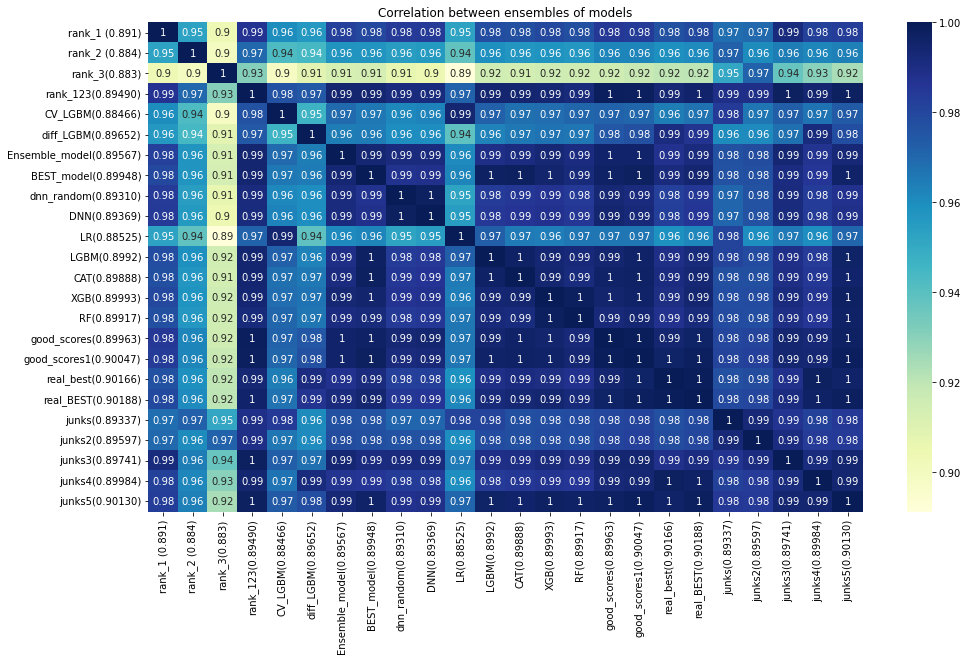

In [23]:
# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (16,9))
g = sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
g.set_title("Correlation between ensembles of models")
plt.show()

- ADA BOOST 는 상관계수가 너무 작아 시각화에서 제외 상관계수가 0.55근처를 유지함

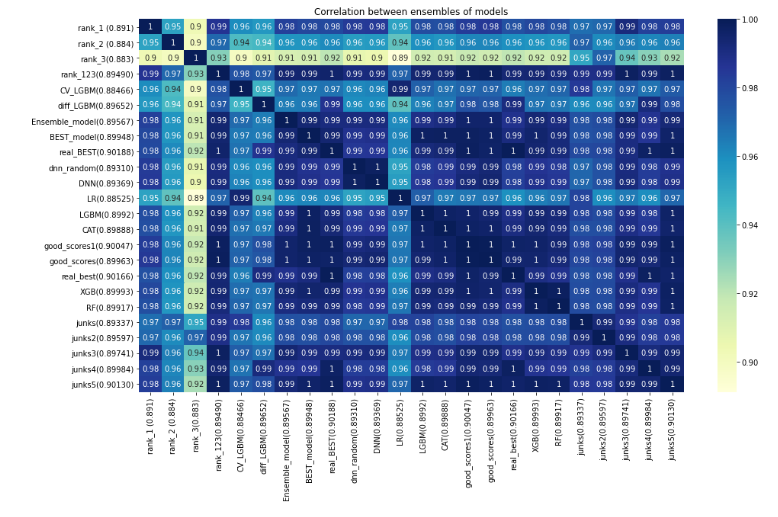

In [24]:
# Mean agreement
(data.corr().sum()-1)/(data.corr().shape[0]-1)

rank_1 (0.891)             0.972899
rank_2 (0.884)             0.955500
rank_3(0.883)              0.918366
rank_123(0.89490)          0.987411
CV_LGBM(0.88466)           0.965166
diff_LGBM(0.89652)         0.963972
Ensemble_model(0.89567)    0.981900
BEST_model(0.89948)        0.982522
dnn_random(0.89310)        0.977817
DNN(0.89369)               0.978311
LR(0.88525)                0.959886
LGBM(0.8992)               0.982363
CAT(0.89888)               0.982119
XGB(0.89993)               0.982834
RF(0.89917)                0.981578
good_scores(0.89963)       0.985657
good_scores1(0.90047)      0.986080
real_best(0.90166)         0.982367
real_BEST(0.90188)         0.984331
junks(0.89337)             0.977461
junks2(0.89597)            0.977264
junks3(0.89741)            0.985127
junks4(0.89984)            0.982724
junks5(0.90130)            0.986507
dtype: float64

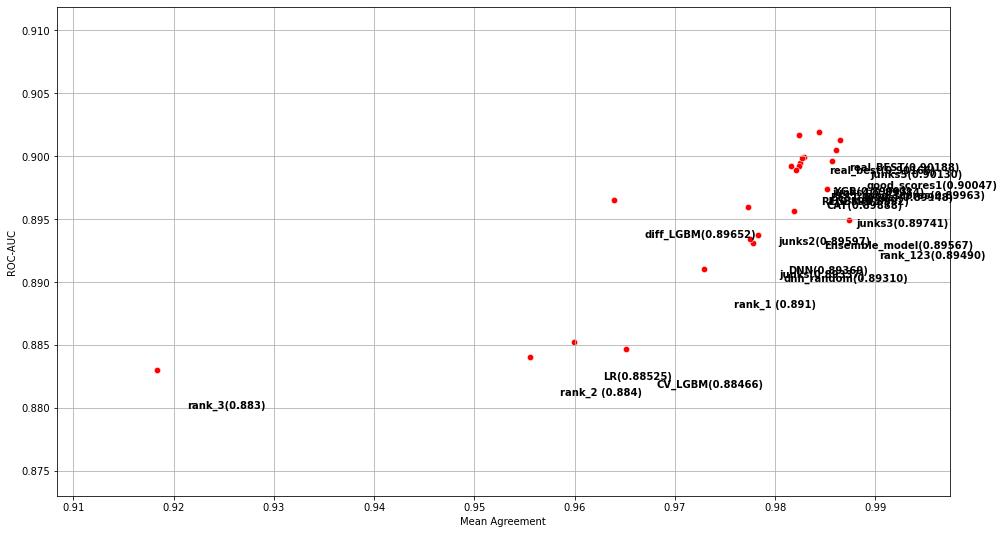

In [25]:
corr = (data.corr().sum()-1)/(data.corr().shape[0]-1)
names = corr.index
aucs = np.array(score).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(16,9))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

- 4가지 모델을 사용했을 때 가장 점수가 높았음
- real_BEST_model 이 가장 점수가 높음

In [ ]:
selected_ensemble_list=[#rank_1,
                        #rank_2,
                        #rank_3,
                        #rank_123,
                        #CV_LGBM,
                        diff_LGBM,
                        #Ensemble_model,                    
                        BEST_model,
                        #real_BEST_model,
                        #dnn_random,
                        #DNN,
                        #LR,
                        #LGBM,
                      #CAT,
                      #ADA,
                      #good_scores1,
                      #good_scores,
                      real_best,
                       XGB,
                       #RF,
                    #junks,
                        #junks2,
                        #junks3,
                    #junks4,
                   #junks5
               ]

In [ ]:
df1=pd.DataFrame(ensemble_list[0]["ID"])
for i in selected_ensemble_list:
    df1=df1.merge(i,on="ID")
data2=df1.iloc[:,1:]

In [ ]:
def ensemble_submission(submissions,p,power=None,name=""):
    if p==0 and power==[]:
        pred=gmean(submissions,axis=1)
        
    elif p!=0 and power==[]:
        pred = (np.sum(np.array(submissions)**p, axis=1) / len(submissions.columns))**(1/p)
    
    else: 
        for i,a in enumerate(power):
            submissions.iloc[:,i]=submissions.iloc[:,i]*a
        pred=np.sum(np.array(submissions),axis=1)/sum(power)
    pd.DataFrame({"ID":df1["ID"],"STATUS":pred}).to_csv(name+"final_submissions.csv",index=False)
    return pd.DataFrame({"ID":df1["ID"],"STATUS":pred})

- p값이 1.5일 때 가장 점수가 높음, 가중평균보다 점수가 높음.

- public_score - > 0.90188
- 최종 앙상블 30회 정도 시도

In [ ]:
ensemble_submission(data2, 1.5, power=[], name="REAL_best")